In [108]:
%load_ext autoreload
%autoreload 2
root_dir = r"c:/Users/aagab/codes/Human_pose/new_statistical_coach/"

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [109]:
import sys
import os

# Get the absolute path to the project root
project_root = os.path.dirname(r"c:/Users/aagab/codes/Human_pose/new_statistical_coach/")
sys.path.insert(0, project_root)
sys.path.insert(0, os.path.join(project_root, 'src'))
sys.path.insert(0, os.path.join(project_root, 'utils'))
# project_root = os.path.dirname(r"c:/Users/aagab/codes/Human_pose/new_statistical_coach/")
# print(sys.path)  # Verify the paths are added

In [110]:
from process_yoga_video import process_yoga_video

> Currently, we are getting HOLD phase features after we are sure of holding the pose for 0.5 seconds

SHAPE OF VELOCITY MAGNITUDE: torch.Size([557, 33])
SHAPE OF SMOOTHED VELOCITY: torch.Size([557])
Movement detected at frame 1
Hold phase detected at frame 172
HOLD FRAME NUMBER: 201


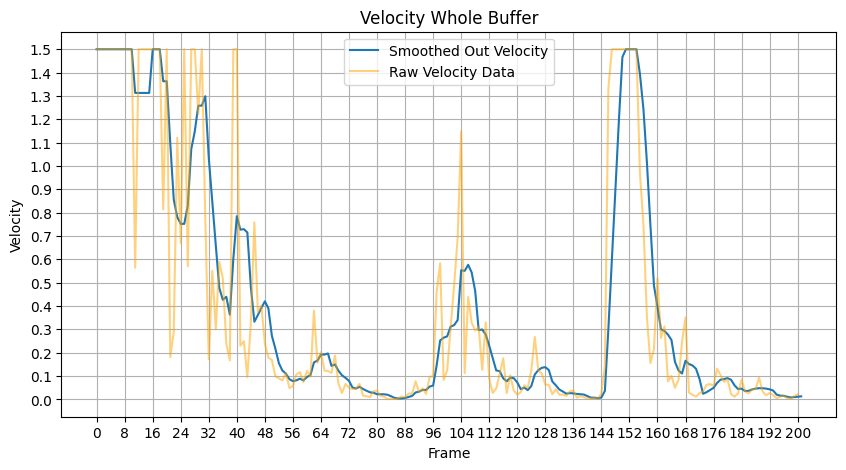

{0: (<PoseState.WAITING: 'waiting'>, 1), 1: (<PoseState.MOVEMENT: 'movement'>, 201), 202: (<PoseState.HOLD: 'hold'>, 0)}
Start Time: 0.016666666666666666
End Time: 4.366666666666666
Frame Rate: 60.0
Segment saved: clipped_videos_chair.mp4\movement_1_262.mp4


In [111]:
video_path = os.path.join(root_dir, "clips_for_dev/chair.mp4")
s = process_yoga_video(video_path, give_segmented_clip=True)

{0: {'right_shoulder_3d': tensor(147.4330, dtype=torch.float64), 'left_shoulder_3d': tensor(152.8704, dtype=torch.float64), 'right_elbow_3d': tensor(141.3450, dtype=torch.float64), 'left_elbow_3d': tensor(125.6042, dtype=torch.float64), 'right_hip_3d': tensor(105.4630, dtype=torch.float64), 'left_hip_3d': tensor(104.0433, dtype=torch.float64), 'right_knee_3d': tensor(117.4379, dtype=torch.float64), 'left_knee_3d': tensor(111.1759, dtype=torch.float64), 'right_ankle_3d': tensor(110.8446, dtype=torch.float64), 'left_ankle_3d': tensor(121.6894, dtype=torch.float64)}, 1: {'right_shoulder_3d': tensor(147.5188, dtype=torch.float64), 'left_shoulder_3d': tensor(152.6257, dtype=torch.float64), 'right_elbow_3d': tensor(141.0184, dtype=torch.float64), 'left_elbow_3d': tensor(125.8968, dtype=torch.float64), 'right_hip_3d': tensor(105.3011, dtype=torch.float64), 'left_hip_3d': tensor(103.8839, dtype=torch.float64), 'right_knee_3d': tensor(117.3327, dtype=torch.float64), 'left_knee_3d': tensor(111.4

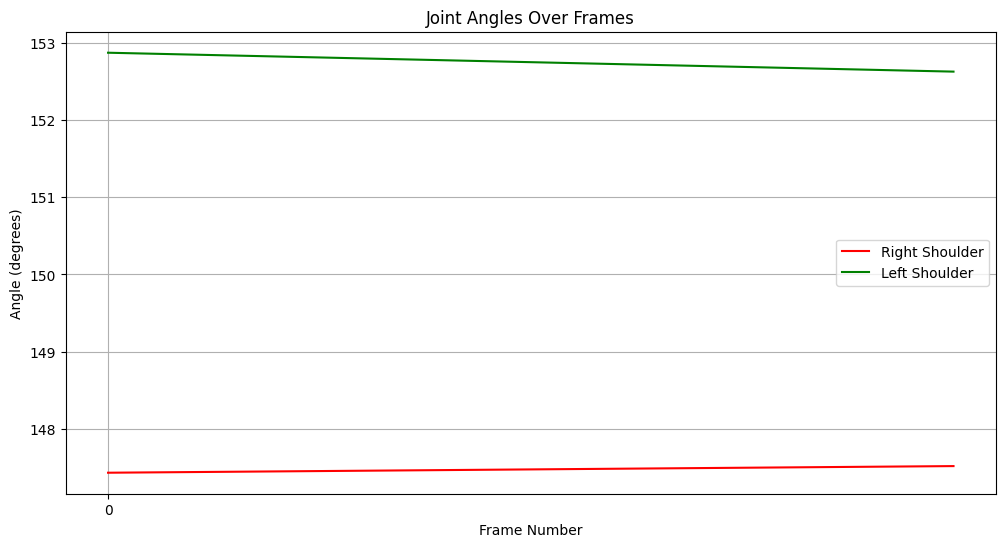

In [290]:
joint_angle_values = s[1]
print(joint_angle_values)
print("Length of return:", len(joint_angle_values))
from plot_joint_angles import plot_joint_angles

plot_joint_angles(joint_angle_values)

In [114]:
# removes _3d prefix
jav = {}
for k, v in joint_angle_values.items():
    jav[k] = {ik[:-3]: iv for ik, iv in v.items()}

In [260]:
from yoga_pose_target_data import joint_configs
jav[0]
detailed_jav = {}
for k, v in jav[0].items():
    reference_joints = joint_configs[k]['joint_names']
    detailed_jav[k] = (reference_joints, v)
    # print(reference_joints)
    
# detailed_jav

In [261]:
import torch
from typing import Dict, Tuple, List, Any, Union
from yoga_pose_target_data import ACTION_JOINT_MAPPING, TARGET_ANGLES, poses

def format_angle_data(angle_data: Dict[str, Union[Tuple, torch.Tensor]]) -> Dict[str, float]:
    """
    Convert the raw angle data into a clean dictionary of float values
    """
    formatted_data = {}
    for joint, data in angle_data.items():
        # Check if the data is a tuple (joints, angle) or just an angle
        if isinstance(data, tuple):
            angle = data[1]
        else:
            angle = data
        
        # Convert tensor to float
        if isinstance(angle, torch.Tensor):
            formatted_data[joint] = float(angle)
        else:
            formatted_data[joint] = float(angle)
    
    return formatted_data

def generate_pose_feedback_prompt(
    user_angles: Dict[str, Any],
    target_angles: Dict[str, Any],
    action_type: str,
    joint_configs: Dict[str, Dict[str, Any]]
) -> str:
    """
    Generate a structured prompt for pose feedback
    
    Parameters:
    - user_angles: Dictionary of current user joint angles
    - target_angles: Dictionary of target joint angles
    - action_type: Type of pose/action being performed
    - joint_configs: Configuration dictionary containing joint relationships
    
    Returns:
    - Formatted prompt string
    """
    # Format the angle data
    # print(user_angles)
    user_angles_clean = format_angle_data(user_angles)
    target_angles_clean = format_angle_data(target_angles)
    
    # print("User Angles Clean:", user_angles_clean)
    # print("Target Angles Clean:", target_angles_clean)
    # Get relevant joints for this action
    relevant_joints = ACTION_JOINT_MAPPING.get(action_type, [])
    # print("Relevant Joints:", relevant_joints) 
    # Build the prompt
    # action_type = 'downward dog'
    prompt_parts = [
        f"Action: {action_type} Pose\n",
        "Current Joint Analysis:\n"
    ]
    
    # Add joint-specific information
    for joint in relevant_joints:
        if joint in user_angles_clean and joint in target_angles_clean:
            current_angle = user_angles_clean[joint]
            target_angle = target_angles_clean[joint]
            # print(current_angle)
            
            # Get involved body parts from joint_configs
            involved_parts = joint_configs[joint]['joint_names']
            
            prompt_parts.append(
                f"- {joint.replace('_', ' ').title()}:\n"
                f"  Current: {current_angle:.1f}°\n"
                f"  Target: {target_angle:.1f}°\n"
                f"  Involved parts: {', '.join(involved_parts)}\n"
            )
    
    # Add instruction for the language model
    # prompt_parts.extend([
    #     "\nContext:",
    #     f"- This is a {action_type.replace('_', ' ')} position",
    #     "- Angles represent the degree between connected body parts",
    #     "- 180° represents a straight line\n",
    #     "Task: Based on these angles, provide clear, simple feedback in 5-10 words",
    #     "focusing on the most important corrections needed for proper form.",
    #     "Prioritize larger deviations and maintain bilateral symmetry where appropriate.",
    #     "Don't use numbers simply use words used by a typical yoga coach or a fitness coach, but use simple words.",
    #     "Focus only on the most significant flaw, first go though all the deviations and find out one that is affecting the pose most.",
    #     "Give direct feedback about the most significant flaw about what should be done like a direct coach but limit to 5 - 10 words output only what coach would say.",
    # ])
   # Edit in the prompt
    prompt_parts.extend([
        "\nContext:",
        f"- This is a {action_type.replace('_', ' ')} position.",
        "- Focus on angles representing proper body alignment.",
        "Task: Respond ONLY with the coach's feedback in 5-10 words. Avoid any extra explanations or numbers.",
        "Keep it short, direct, and actionable, like a yoga instructor would.",
        "Only focus on most significant flaw and give output like the user is listening while doing the pose."
    ])
 
    return "\n".join(prompt_parts)

In [262]:
# Extract pose name from video path
pose = os.path.splitext(os.path.basename(video_path))[0]
prompt = generate_pose_feedback_prompt(detailed_jav, TARGET_ANGLES[pose], pose, joint_configs)
print(prompt)

Action: chair Pose

Current Joint Analysis:

- Right Hip:
  Current: 105.5°
  Target: 120.0°
  Involved parts: right_shoulder, right_hip, right_knee

- Left Hip:
  Current: 104.0°
  Target: 120.0°
  Involved parts: left_shoulder, left_hip, left_knee

- Right Knee:
  Current: 117.4°
  Target: 120.0°
  Involved parts: right_hip, right_knee, right_ankle

- Left Knee:
  Current: 111.2°
  Target: 120.0°
  Involved parts: left_hip, left_knee, left_ankle

- Right Shoulder:
  Current: 147.4°
  Target: 180.0°
  Involved parts: right_elbow, right_shoulder, right_hip

- Left Shoulder:
  Current: 152.9°
  Target: 180.0°
  Involved parts: left_elbow, left_shoulder, left_hip


Context:
- This is a chair position.
- Focus on angles representing proper body alignment.
Task: Respond ONLY with the coach's feedback in 5-10 words. Avoid any extra explanations or numbers.
Keep it short, direct, and actionable, like a yoga instructor would.
Only focus on most significant flaw and give output like the user i

In [283]:
from Language_Model import get_llama_feedback

model_feedback = get_llama_feedback(prompt, temperature=0)

Right shoulder, relax and open it further, please.

In [284]:
from text_to_speech import text_to_speech

In [285]:
audio = text_to_speech(model_feedback)
def inline_audio(audio):
    from IPython.display import Audio, display
    SAMPLE_RATE = 22050
    display(Audio(audio, rate=SAMPLE_RATE))

inline_audio(audio)


Generating speech for: 'Right shoulder, relax and open it further, please.'
Debug - Processed phonemes: 'ɹˈaɪt ʃˈoʊldɚ, ɹᵻlˈaeks aend ˈoʊpən ɪt fˈɜːðɚ, plˈiːz.'

Audio saved to output_sound\output.wav
Generated phonemes: ɹˈaɪt ʃˈoʊldɚ, ɹᵻlˈaeks aend ˈoʊpən ɪt fˈɜːðɚ, plˈiːz.


In [286]:
from Language_Model import get_local_language_model_feedback
model_feedback = get_local_language_model_feedback(prompt, temperature=0)

Right Shoulder too far forward; pull back more.


In [287]:
audio = text_to_speech(model_feedback)
inline_audio(audio)


Generating speech for: 'Right Shoulder too far forward; pull back more.'
Debug - Processed phonemes: 'ɹˈaɪt ʃˈoʊldɚ tˈuː fˈɑːɹ fˈɔːɹwɚd; pˈʊl bˈaek mˈɔːɹ.'

Audio saved to output_sound\output.wav
Generated phonemes: ɹˈaɪt ʃˈoʊldɚ tˈuː fˈɑːɹ fˈɔːɹwɚd; pˈʊl bˈaek mˈɔːɹ.
